<a href="https://colab.research.google.com/github/ychikawa/quantize/blob/main/tflite_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow

## Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
mnist = tf.keras.datasets.mnist
(images_train, labels_train),(images_test, labels_test) = mnist.load_data()
class_names = ["zero","one","two","three","four","five","six","seven","eight","nine"]

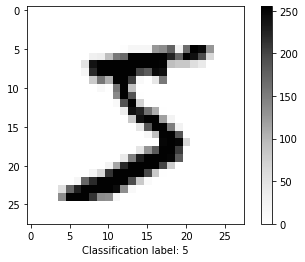

In [ ]:
plt.figure()
plt.rcParams['image.cmap']='Greys'
plt.imshow(images_train[0])
plt.grid(False)
plt.xlabel("Classification label: {}".format(labels_train[0]))
plt.colorbar()
plt.show()

In [ ]:
images_train=images_train/255.0
images_test=images_test/255.0

## Model training

In [ ]:
model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=(28,28)),
  keras.layers.Dense(512, activation=tf.nn.relu),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(512, activation=tf.nn.relu),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(images_train, labels_train, epochs=16, batch_size=1024)

Epoch 1/16
59/59 [==============================] - 5s 9ms/step - loss: 0.5103 - accuracy: 0.8512
Epoch 2/16
59/59 [==============================] - 0s 8ms/step - loss: 0.1798 - accuracy: 0.9470
Epoch 3/16
59/59 [==============================] - 0s 7ms/step - loss: 0.1214 - accuracy: 0.9635
Epoch 4/16
59/59 [==============================] - 1s 9ms/step - loss: 0.0941 - accuracy: 0.9713
Epoch 5/16
59/59 [==============================] - 0s 8ms/step - loss: 0.0743 - accuracy: 0.9774
Epoch 6/16
59/59 [==============================] - 0s 7ms/step - loss: 0.0602 - accuracy: 0.9810
Epoch 7/16
59/59 [==============================] - 0s 7ms/step - loss: 0.0510 - accuracy: 0.9844
Epoch 8/16
59/59 [==============================] - 0s 7ms/step - loss: 0.0410 - accuracy: 0.9873
Epoch 9/16
59/59 [==============================] - 0s 7ms/step - loss: 0.0370 - accuracy: 0.9885
Epoch 10/16
59/59 [==============================] - 0s 8ms/step - loss: 0.0304 - accuracy: 0.9905
Epoch 11/16
59/59 [

## Testing

In [ ]:
test_loss, test_acc = model.evaluate(images_test, labels_test)
print('Test accuracy:', test_acc)

313/313 [==============================] - 2s 5ms/step - loss: 0.0599 - accuracy: 0.9827
Test accuracy: 0.982699990272522


# TFLite

## TF to TFLite

In [ ]:
mnist_ds = tf.data.Dataset.from_tensor_slices((images_train.astype('float32'))).batch(1)
def representative_data_gen():
  for input_value in mnist_ds.take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()
with open('model.tflite', 'wb') as o_:
    o_.write(tflite_quant_model)

/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


## Sample

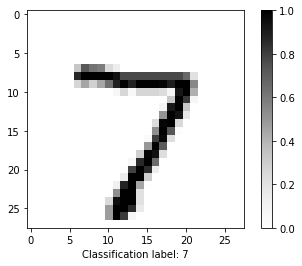

In [ ]:
index = 0
sample = images_test[index]
plt.figure()
plt.rcParams['image.cmap']='Greys'
plt.imshow(sample)
plt.grid(False)
plt.xlabel("Classification label: {}".format(labels_test[index]))
plt.colorbar()
plt.show()

## TFLite inference

In [ ]:
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
scale, zero_point = input_details[0]['quantization']
print("Scale :", scale, "  ", "Zero Point :", zero_point)
int_image = np.around(sample.astype('float32')/scale+zero_point).astype('int8')
int_image = np.expand_dims(int_image, axis=0)
interpreter.set_tensor(input_details[0]['index'], int_image)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])
print(output)
print("Prediction :", np.argmax(output))

Scale : 0.003921568859368563    Zero Point : -128
[[-128 -128 -128 -128 -128 -128 -128  127 -128 -128]]
Prediction : 7


In [ ]:
fc0_w = interpreter.get_tensor(7)
fc0_b = interpreter.get_tensor(6)
fc0_w_scale = interpreter.get_tensor_details()[7]['quantization_parameters']['scales'][0]
fc0_b_scale = interpreter.get_tensor_details()[6]['quantization_parameters']['scales'][0]
fc0_scale = interpreter.get_tensor_details()[9]['quantization_parameters']['scales'][0]
fc0_zero_point = interpreter.get_tensor_details()[9]['quantization_parameters']['zero_points'][0]
fc1_w = interpreter.get_tensor(5)
fc1_b = interpreter.get_tensor(4)
fc1_w_scale = interpreter.get_tensor_details()[5]['quantization_parameters']['scales'][0]
fc1_b_scale = interpreter.get_tensor_details()[4]['quantization_parameters']['scales'][0]
fc1_scale = interpreter.get_tensor_details()[10]['quantization_parameters']['scales'][0]
fc1_zero_point = interpreter.get_tensor_details()[10]['quantization_parameters']['zero_points'][0]
fc2_w = interpreter.get_tensor(3)
fc2_b = interpreter.get_tensor(2)
fc2_w_scale = interpreter.get_tensor_details()[3]['quantization_parameters']['scales'][0]
fc2_b_scale = interpreter.get_tensor_details()[2]['quantization_parameters']['scales'][0]
fc2_scale = interpreter.get_tensor_details()[11]['quantization_parameters']['scales'][0]
fc2_zero_point = interpreter.get_tensor_details()[11]['quantization_parameters']['zero_points'][0]

In [ ]:
np.set_printoptions(suppress=True)
int_image = int_image.reshape(-1)
result = fc0_w.astype('int32')@int_image.astype('int32') - zero_point*np.sum(fc0_w, 1) + fc0_b
result = np.clip(result, 0, None)
result = result*(fc0_b_scale/fc0_scale)+fc0_zero_point
result = np.clip(result, -128, 127)
result = np.round(result).astype('int8')
result = fc1_w.astype('int32')@result.astype('int32') - fc0_zero_point*np.sum(fc1_w, 1) + fc1_b
result = np.clip(result, 0, None)
result = result*(fc1_b_scale/fc1_scale)+fc1_zero_point
result = np.clip(result, -128, 127)
result = np.round(result).astype('int8')
result = fc2_w.astype('int32')@result.astype('int32') - fc1_zero_point*np.sum(fc2_w, 1) + fc2_b
result = result*(fc2_b_scale/fc2_scale)+fc2_zero_point
result = np.round(result).astype('int8')
print(np.argmax(result))

7
